# Modeling Quadrupole Transport of Charged Particle Beams with Python
Created by Emily Jevarjian, Nick Valverde, and Steve Lund 


The purpose of this code is model the phase space evolution of a beam of charged particles transported in a magnetic FODO quadrupole focusing lattice. The focusing is alternating gradient. This program describes the quadrupoles simply as "thin lens" kicks and uses linear transfer matrices to model the charged particle beam's transport. Approximate, corresponding thick (physical) quadrupole parameters are output for laboratory implementation.

User inputs are specified to set desired charged particle beam and applied focusing lattice parameters. Options can be set to model a single particle or a bundle of particles. Output plots generated help visualize the the phase-space evolution of the beam.  Plots include x and x' orbit bundles and x-x' phase-space projections made each lattice period at the same location.     

The program employs Python packages numpy and math to make calculations and uses matplotlib graphics to plot the phase space evolution of the beam.

# Load Python Packages 

In [1]:
import numpy as np
from numpy import cos, sin, pi
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Define Constants

In [2]:
# Constants

c_light  = 2.99792458e8    # speed of light [m/s]
e_charge = 1.60217662e-19  # electronic charge [C]
amu      = 1.660538921e-27 # atomic mass unit [kg]
jperev   = e_charge        # conversion factor Joules/eV
mm       = 1.e-3           # conversion factor mm to meters 
mrad     = 1.e-3           # conversion factor mrad to rad 

# Charged Particle Inputs
* Q:  particle charge state
    * Q = -1 for an electron
    * Q = a positive integer for an ion
* M:  particle mass in atomic mass units [amu]
* E:  axial kinetic energy [eV]

In [3]:
# Charged particle inputs
Q  = 1           # particle charge state [1]
M  = 1.00727647  # particle mass [amu]
E  = 100.e3      #axial kinetic energy [eV]

# Derived parameters 
q = Q*e_charge 
m = M*amu 

energy   = jperev*E                    # Kinetic energy [J]
gamma_b  = 1. + energy/(m*c_light**2)  # relativistic axial gamma [1]
beta_b   = np.sqrt(1.-1./gamma_b**2)   # relativistic axial beta v_z/c [1]
p_z      = m*gamma_b*beta_b*c_light    # particle axial momentum [kg*m/s]
rigidity = p_z/q                       # particle rigidity [T*m]

print("q = {} C" .format(q))
print("Mass = {} kg" .format(m))

q = 1.60217662e-19 C
Mass = 1.672621782642489e-27 kg


## Beam Distribution Inputs

In [4]:
# # Beam distribution inputs
# Np        = 1    #number of particles [1] must be positive integer 
# emit = 1.  # emittance [mm*mrad]

# beta  = 1.       # betatron ellipse coefficient beta [m]
# alpha = pi/4. # betatron ellipse coefficient alpha [rad]

# fill  = False   # False = Particles on perimeter ellipse, True = Particles uniformly fill ellipse 
# match = False   # False = Use beta, alpha above to set, True = Reset beta, alpha as matched beam ellipse values

# # Derived distrubtion parameters 
# gamma = (1+alpha**2)/beta # betatron ellipse coefficient gamma [1/m]

# emittance  = emit*mm*mrad # emittance in [meter*rad] units 

# w  = beta**0.5  # alternative betatron ellipse parameter w [m^0.5]
# wp = -alpha/w   # alternative betatron ellipse parameter wp = w' [m^-0.5]

# print("gamma = {} 1/m" .format(gamma))
# print("beta = {} m" .format(beta))
# print("alpha = {} rad" .format(alpha))
# print("w = {} m^0.5" .format(w))
# print("w' = {} m^-0.5" .format(wp))

## FODO Lattice Inputs

In [5]:
Np = 1   #Number of particles
emittance = 1.*mm*mrad
sigma_0 = pi/3 #phase angle. This angle gives a f = 4 to match single particle thin lens code.
d = 2.         #[m] full drift length
Lp = 2*d       #[m]  lattice length

#--Calculate focal length f through stability criterion
f = (d/2)*np.sqrt(2/(1-cos(sigma_0))) #focal length

ell     = 0.5 # Physical (thick) quadrupole axial length [m]  (information only for lab lattice output)

kappa = 1./(f*ell)           # Physical (thick) quadrupole kappa [1/m^2]
G     = rigidity/(f*ell)     # Physical (thick) quadrupole field gradient [Tesla/m]

print("Focal Length = {} m" .format(f))
print("G = {}" .format(G))

Focal Length = 2.0 m
G = 0.04569516484432219


## Procedure for creating matched distriubtion of particles

In [6]:
#--Functions to calcluate Twiss parameters with inputs drift (d), focal length (f), and initial phase-angle (sigma_0).
def alpha_func(d,f, sigma_0):
    numerator = -d/f
    denominator = np.sqrt(sin(sigma_0))
    return numerator/denominator

def beta_func(d, f, sigma_0):
    numerator = 2*d - d**3/(4*f**2)
    denominator = sin(sigma_0)
    return numerator/denominator

def gamma_func(d, f, sigma_0):
    numerator = sin(sigma_0) + d**2/f**2
    denominator = 2*d - d**3/(4*f**2)
    return numerator/denominator




def create_particles (d, f, sigma_0, emittance, Np, fill = False, match = True):
    '''
    Create distribution of initial x,x' coordinates for n particles in specified Courant-Snyder 
    phase-space ellipse given by 
       gamma*x^2 + 2*alpha*x*x' + beta*(x')^2 = emit
    Filled = False => distribute n particles around perimeter 
           = True  => uniformly fill n particles within ellipse 
    Note: This routine has no knowledge of whether the ellipse parameters gamma, alpha, beta, emit 
    correspond to a matched beam or not. 
    '''
    
    #--Initialze x and x' arrays to be populated
    x = []
    xprime = []
    count = 0 #Counter for while loops

    #--Check Match condition
    if match == True:
        #--Calculate twiss parameters along with w and w'
        alpha, betta, gamma = alpha_func(d, f, sigma_0), beta_func(d, f, sigma_0), gamma_func(d, f, sigma_0)
        #--Calculate w
        numerator = np.sqrt(2.*d - d**3/(4.*f**2))
        denom = np.sqrt(sin(sigma_0))
        w = numerator/denom
        #--Calculate w'
        numerator = d/f
        denom = np.sqrt(2.*d - d**3/(4.*f**2))
        wp = numerator/denom
        #--Use derived w and w' to evaluate x and x'
        if fill == False: # Perimeter load
             while count < Np:
                theta = 2*pi*count/Np
                xpos = np.sqrt(emittance)*w*cos(theta)
                xprime_pos = np.sqrt(emittance)*sin(theta)/w + np.sqrt(emittance)*wp*cos(theta)

                x.append(xpos)
                xprime.append(xprime_pos)
                count += 1
        else: # Uniform load
            while count < Np:
             #--Fill  Procedure
                up = np.random.random()
                upsi = np.random.random()
                psi = 2*pi*upsi
                xpos = np.sqrt(emittance*np.sqrt(up))*w*cos(psi)
                xprime_pos = np.sqrt(emittance*np.sqrt(up))*sin(psi)/w + np.sqrt(emittance*np.sqrt(up))*wp*cos(psi)

                x.append(xpos)
                xprime.append(xprime_pos)
                count +=1
        #--Output twiss parameters
        print("alpha = %f" %alpha)
        print("betta = %f[m]" %betta)
        print("gamma = %f" %gamma)
        print("w = %f" %w)
        print("w' = %f" %wp)


    #--If matched conditions is not desired use random number generator
    else: 
        while count < Np: #loop until the x and x' list have the desired number of particles
            x.append(np.random.uniform(-1e-3,1e-3)) #mm
            xprime.append(np.random.uniform(-1e-3,1e-3)) #mm/s
            count += 1
   
    #--Turn x and xprime into np arrays 
    x = np.array(x)
    xprime = np.array(xprime)


    return x, xprime

In [7]:
x, xprime = create_particles(d, f, sigma_0, emittance, Np, fill = False, match = True)

alpha = -1.074570
betta = 4.041452[m]
gamma = 0.533150
w = 2.010336
w' = 0.534522


In [8]:
xtest, xptest = x[0], xprime[0]
alpha = -.537285
betta = 4.474465
gamma = 0.288007
wtest = 2.115293
wptest = 0.254000

In [9]:
test1_emit = gamma*xtest**2 + 2*alpha*xtest*xptest + betta*xptest**2
test2_emit = (xtest/wtest)**2 + (wptest*xptest - wptest*xtest)**2

In [10]:
first_test = 100*(abs(emittance - test1_emit)/emittance)
second_test = 100*(abs(emittance - test2_emit)/emittance)

In [11]:
print(first_test)
print(second_test)

28.76843926384244
4.3743373914632535


## Procedure to advance particles through lattice

In [12]:
#-Create FODO Matrices
M0 = np.array( [[1.,d/2.],[0,1.]] )      # drift matrix
Mf = np.array( [[1.,0],[-1./f,1.]] )     # focus matrix
Md = np.array( [[1.,0],[ 1./f,1.]] )     # defocus matrix
def advance(x, xprime, Matrix): #advance particles 
    x_new = []
    xprime_new = []

    #The create_particles gives two arrays of intitial particle coordinates. For each particle, take the 
    #x and x' coordintates and advance through the FODO element Matrix. Then, append the new coordinates to x_new
    #and xprime_new and update x and xprime at the end. 
    for i in range(len(x)):
        a = x[i] #a and b aid in creating vec
        b = xprime[i]
        vec = np.array([[a], [b]])
        
        #advance particle
        vec = Matrix@vec 
        #append new coordinates
        
        x_new.append(vec[0][0]) #append new 
        xprime_new.append(vec[1][0])
    
    #update original x and xprime
    x, xprime = np.array(x_new), np.array(xprime_new)
    return x, xprime


## Ellipse Plot Routine


In [13]:
def ellipse_plot(x, xprime):
    #--Major axis coordinates
    x_axis_coords = []
    for k in range(len(x)):
        if x[k] == max(x):
            x_axis_coords.append(x[k])
            x_axis_coords.append(xprime[k])
        else:
            continue
            
    xp_axis_coords = []
    for k in range(len(xprime)):
        if xprime[k] == max(xprime):
            xp_axis_coords.append(x[k])
            xp_axis_coords.append(xprime[k])
        else:
            continue
    
            
    fig, ax = plt.subplots(figsize=(7,7))
    ax.scatter(x/mm, xprime/mm, s = 0.5)
    ax.axhline(y=0, lw=.5, c='k')
    ax.axvline(x=0, lw=.5, c='k')
    ax.set_title(r"d = %g[m], f = %g[m], $\sigma_0 = $%g[rad] " %(d, f, sigma_0), fontsize = 18)
    ax.set_xlabel(r'$x$[mm]', fontsize = 18)
    ax.set_ylabel(r"x'[mrad]", fontsize = 18)
    
    #ax.plot([2,2], [0,.4], lw=.75) #[x1, x2], [y1, y2]
    
    x_axis_coords = np.array(x_axis_coords)
    xp_axis_coords = np.array(xp_axis_coords)
    
    #--Add major axis
    x1,x2, y1, y2 = 0, x_axis_coords[0]/mm, 0, x_axis_coords[1]/mm
    ax.plot([x1,x2], [y1,y2], c = 'k', lw = .75) # x-axis 
    x_annote = "xmax = %1.3f" %(x_axis_coords[0]/mm)
    ax.annotate(x_annote, x_axis_coords/mm)

    #--Add minor axis
    x1,x2, y1, y2 = 0, xp_axis_coords[0]/mm, 0, xp_axis_coords[1]/mm
    ax.plot([x1,x2], [y1,y2], c = 'k', lw = .75) # x-axis 
    xp_annote = "x'max = %1.3f" %(xp_axis_coords[1]/mm)
    ax.annotate(xp_annote, xp_axis_coords/mm)
    return True

## Main proedure

alpha = -1.074570
betta = 4.041452[m]
gamma = 0.533150
w = 2.010336
w' = 0.534522


True

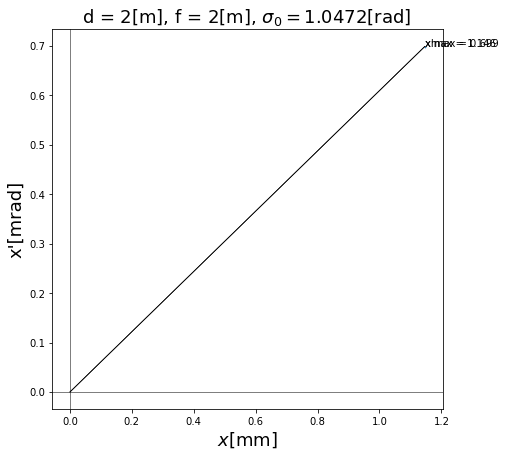

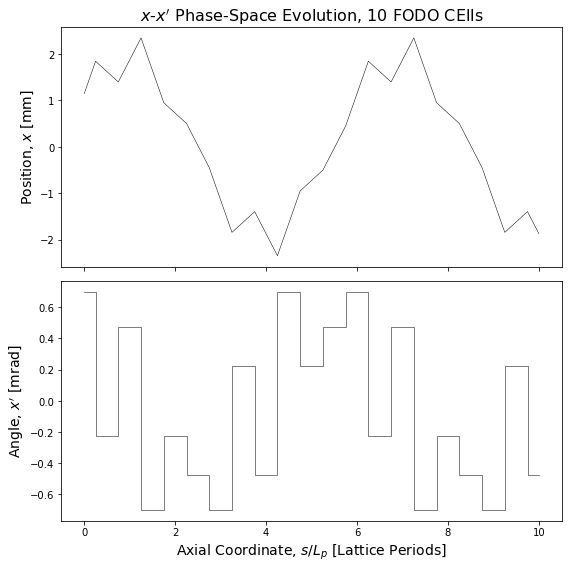

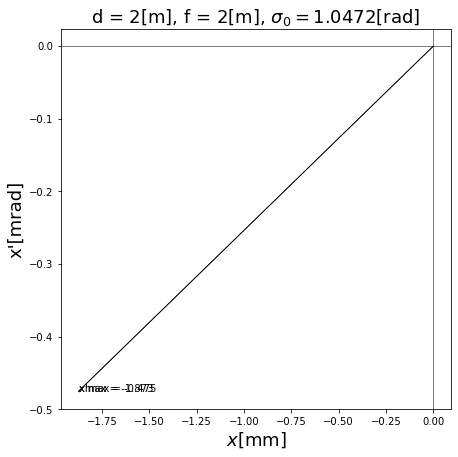

In [15]:
#Create particles
x, xprime= create_particles(d, f, sigma_0, emittance, Np, fill = True, match = True)
ellipse_plot(x, xprime)

n_advance = 10
x_history = [x]
xp_history = [xprime]
s_history = [0]
s = 0
lattice_advances = 0
while lattice_advances < n_advance:
    #Pass through half-drift
    x, xprime = advance(x,xprime, M0)
    x_history.append(x)
    xp_history.append(xprime)
    s += d/2.
    s_history.append(s)
    
    #Pass through focus
    x, xprime = advance(x, xprime, Mf)
    x_history.append(x)
    xp_history.append(xprime)
    s += 0
    s_history.append(s)

    
     #Pass through two half-drifts 
    x, xprime = advance(x,xprime, M0)
    x_history.append(x)
    xp_history.append(xprime)
    s += d/2.
    s_history.append(s)

    x, xprime = advance(x,xprime, M0)
    x_history.append(x)
    xp_history.append(xprime)
    s += d/2.
    s_history.append(s)
    
    #Pass through defocus
    x, xprime = advance(x, xprime, Md)
    x_history.append(x)
    xp_history.append(xprime)
    s += 0
    s_history.append(s)
    
    #Pass through half-drift
    x, xprime = advance(x,xprime, M0)
    x_history.append(x)
    xp_history.append(xprime)
    s += d/2.
    s_history.append(s)
    
    lattice_advances += 1
    
    
x_history = np.array(x_history)
xp_history = np.array(xp_history)    
s_history = np.array(s_history)

#--Plot x and x' trajectories
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (8,8), sharex = True)
ax_pos = axes[0]
ax_phase_space = axes[1]

ax_pos.plot(s_history/Lp, x_history/mm, c = 'k', lw = .5)
ax_pos.set_title(r"$x$-$x'$ Phase-Space Evolution, %g FODO CElls" %n_advance, fontsize = 16)
ax_pos.set_ylabel(r'Position, $x$ [mm]', fontsize = 14)

ax_phase_space.plot(s_history/Lp, xp_history/mrad, c = 'k', lw = .5)
#ax_phase_space.set_title('Phase Space Evolution through %g FODO Cells' %n_advance)
ax_phase_space.set_ylabel(r"Angle, $x'$ [mrad]", fontsize = 14)
ax_phase_space.set_xlabel(r"Axial Coordinate, $s/L_p$ [Lattice Periods]", fontsize = 14)
plt.tight_layout()

#--Plot final ellipse
ellipse_plot(x,xprime)